In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, glob

path = '../input/betting-lines/'

all_betting = glob.glob(os.path.join(path, '*.xlsx'))


all_df = []

for f in all_betting:
    df = pd.read_excel(f)
    df['Season'] = '20'+ f[-7:-5]
    all_df.append(df)
    
merged_df = pd.concat(all_df,ignore_index=True, sort=True)

merged_df = merged_df.drop(['1st','2nd','Open','2H'],axis=1)

merged_df



,Close,Date,Final,ML,Rot,Season,Team,VH
0,157,1110,65.0,290,711,2009,GeorgiaSouthern,N
1,7.5,1110,63.0,-350,712,2009,HoustonU,N
2,139.5,1110,49.0,7500,713,2009,Presbyterian,V
3,35,1110,80.0,-20000,714,2009,Duke,H
4,127.5,1111,60.0,255,517,2009,IUPUI,N
...,...,...,...,...,...,...,...,...
95725,3.5,402,70.0,-170,812,2011,Butler,N
95726,2.5,402,55.0,-150,813,2011,Kentucky,N
95727,139,402,56.0,130,814,2011,Connecticut,N
95728,132,404,41.0,140,601,2011,Butler,N


In [3]:
index = 0
new_df = []
while index<len(merged_df.index):
    i=index
    new_row = merged_df.iloc[[i,i+1]]
    index+=2
    if new_row.Final[i]>new_row.Final[i+1]:
        winner=new_row.Team[i]
    else:
        winner=new_row.Team[i+1]
    try:
        float(new_row.Close[i])
    except ValueError:
        continue
    try:
        float(new_row.ML[i])
    except ValueError:
        continue
    if new_row.Close[i]>100.0:
        line=new_row.Close[i+1]
        favorite=new_row.Team[i+1]
        underdog_score = new_row.Final[i]
        favorite_score = new_row.Final[i+1]
    else:
        line=new_row.Close[i]
        favorite=new_row.Team[i]
        underdog_score = new_row.Final[i+1]
        favorite_score = new_row.Final[i]
    if float(new_row.ML[i])>0:
        ML=new_row.ML[i+1]
    else:
        ML=new_row.ML[i]
    MoV = favorite_score - underdog_score
    new_df.append({'Season':new_row.Season[i],'Team1':new_row.Team[i], 'Team2':new_row.Team[i+1],'Favorite':favorite,'Line':line,'Winner':winner,'ML':ML,'MoV':MoV})
    
    
df1 = pd.DataFrame(new_df)

In [4]:
df1 = df1[['Season','Team1','Team2','Line','ML','Favorite','Winner','MoV']]

In [5]:
from copy import deepcopy

indexNames = df1[df1['Winner']==df1['Favorite']].index

df1 = df1.assign(Result=0)

df1.loc[indexNames,'Result'] = 1

df1

,Season,Team1,Team2,Line,ML,Favorite,Winner,MoV,Result
0,2009,GeorgiaSouthern,HoustonU,7.5,-350,HoustonU,GeorgiaSouthern,-2.0,0
1,2009,Presbyterian,Duke,35,-20000,Duke,Duke,31.0,1
2,2009,IUPUI,Northeastern,7,-310,Northeastern,Northeastern,13.0,1
3,2009,Presbyterian,HoustonU,13,-1100,HoustonU,HoustonU,19.0,1
4,2009,GeorgiaSouthern,Duke,27.5,-8500,Duke,Duke,43.0,1
...,...,...,...,...,...,...,...,...,...
44731,2011,WichitaState,Alabama,2.5,-140,WichitaState,WichitaState,9.0,1
44732,2011,Creighton,Oregon,3.5,-175,Oregon,Oregon,2.0,1
44733,2011,VaCommonwealth,Butler,3.5,-170,Butler,Butler,8.0,1
44734,2011,Kentucky,Connecticut,2.5,-150,Kentucky,Connecticut,-1.0,0


In [6]:
#Drop all games where the line is 0 because there's no favorite
indexNames = df1[df1['Line']=='pk'].index
df1.drop(indexNames,inplace=True)

df1

,Season,Team1,Team2,Line,ML,Favorite,Winner,MoV,Result
0,2009,GeorgiaSouthern,HoustonU,7.5,-350,HoustonU,GeorgiaSouthern,-2.0,0
1,2009,Presbyterian,Duke,35,-20000,Duke,Duke,31.0,1
2,2009,IUPUI,Northeastern,7,-310,Northeastern,Northeastern,13.0,1
3,2009,Presbyterian,HoustonU,13,-1100,HoustonU,HoustonU,19.0,1
4,2009,GeorgiaSouthern,Duke,27.5,-8500,Duke,Duke,43.0,1
...,...,...,...,...,...,...,...,...,...
44731,2011,WichitaState,Alabama,2.5,-140,WichitaState,WichitaState,9.0,1
44732,2011,Creighton,Oregon,3.5,-175,Oregon,Oregon,2.0,1
44733,2011,VaCommonwealth,Butler,3.5,-170,Butler,Butler,8.0,1
44734,2011,Kentucky,Connecticut,2.5,-150,Kentucky,Connecticut,-1.0,0


In [7]:
#if games weren't played bc of delay, best to just drop those games
indexNames = df1[df1['MoV'].isnull()].index.tolist()

df1.drop(indexNames,inplace=True)

indexes = df1[df1['Line']>100].index

df1.drop(indexes,inplace=True)

In [24]:
df1['Cover'] = df1.apply(lambda x: 1 if (x.MoV-x.Line)>0 else 0,axis=1)

print(len(df1[df1['Cover']==1])/len(df1))
print(len(df1[df1['Result']==1])/len(df1))

df1

0.48948908088985643
0.7385309658253396


,Line,MoV,Result,Cover
0,7.5,-2.0,0,0
1,35,31.0,1,0
2,7,13.0,1,1
3,13,19.0,1,1
4,27.5,43.0,1,1
...,...,...,...,...
44731,2.5,9.0,1,1
44732,3.5,2.0,1,0
44733,3.5,8.0,1,1
44734,2.5,-1.0,0,0


In [9]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

x = pd.DataFrame(df1['Line'])
y = pd.DataFrame(df1['MoV'])


model = LinearRegression()

model.fit(x,y)

r_sq = model.score(x,y)
print('coefficient of determination: ' + str(r_sq))

coefficient of determination: 0.22785887879339262


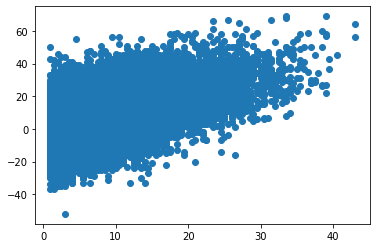

In [10]:
plt.scatter(x,y)
plt.show()

10.825984655141815
12.142119528556991
5.506108616872982


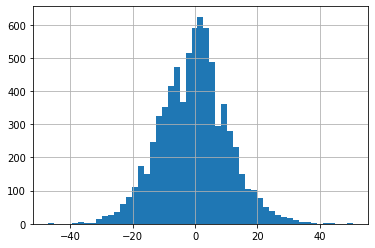

In [11]:
import math

df['diff']=df1['MoV']-df1['Line']

data = df['diff']

w=400
n=math.ceil((data.max())-data.min()/w)

df['diff'].hist(bins=n)

print(np.std(data))
print(np.std(df1['MoV']))
print(np.std(df1['Line']))

In [12]:
df1 = df1.drop(['Season','Team1','Team2','ML','Favorite','Winner'],axis=1)

df_win = df1

indexW = df_win[df_win['Result']==1].index
indexL = df_win[df_win['Result']==0].index

df_lose = df_win.copy()
df_lose['Line'] = df_lose['Line']*-1
df_lose.loc[indexW,'Result'] = 0
df_lose.loc[indexL,'Result'] = 1



df_lose

,Line,MoV,Result,Cover
0,-7.5,-2.0,1,0
1,-35,31.0,0,0
2,-7,13.0,0,1
3,-13,19.0,0,1
4,-27.5,43.0,0,1
...,...,...,...,...
44731,-2.5,9.0,0,1
44732,-3.5,2.0,0,0
44733,-3.5,8.0,0,1
44734,-2.5,-1.0,1,0


In [13]:
df_final = pd.concat((df_win,df_lose)).reset_index(drop=True)

df_final

,Line,MoV,Result,Cover
0,7.5,-2.0,0,0
1,35,31.0,1,0
2,7,13.0,1,1
3,13,19.0,1,1
4,27.5,43.0,1,1
...,...,...,...,...
88189,-2.5,9.0,0,1
88190,-3.5,2.0,0,0
88191,-3.5,8.0,0,1
88192,-2.5,-1.0,1,0


In [14]:
feature_cols=['Line']
X = df_final[feature_cols]
y= df_final.Result

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [17]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cnf_matrix

array([[8234, 2904],
       [2934, 7977]])

In [18]:
print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
print('Precision:',metrics.precision_score(y_test, y_pred))
print('Recall:',metrics.recall_score(y_test, y_pred))
print('Log-Loss:',metrics.log_loss(y_test,y_pred))


Accuracy: 0.7352260873509002
Precision: 0.7331127653708299
Recall: 0.7310970580148474
Log-Loss: 9.145072276494437


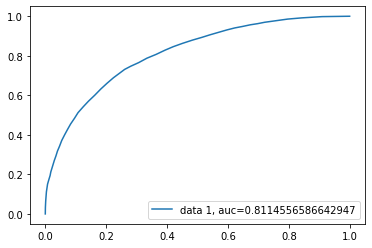

In [19]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label='data 1, auc='+str(auc))
plt.legend(loc=4)
plt.show()